In [23]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.display import HTML

In [2]:
# set up plotting colors
sns.set(rc={'axes.facecolor'   : '#202020', 
            'axes.labelcolor'  : '#e0e0e0',
            'axes.edgecolor'   : '#e0e0e0',
            'axes.grid'        :  False,
            'text.color'       : '#e0e0e0', 
            'figure.facecolor' : '#202020',
            'figure.edgecolor' : '#202020',
            'xtick.color'      : '#e0e0e0',
            'ytick.color'      : '#e0e0e0',
            'legend.fancybox'  : 'true'
           })

octal_seq = [sns.hls_palette(12, 0, .5, .5)[i] for i in [0,1,2,4,7,9]]
octal_cat = [sns.hls_palette(12, 0, .5, .5)[i] for i in [7,1,4,0,9,2]]
octal_unity = [sns.hls_palette(12, 0, .5, .5)[i] for i in [4]]
sns.set_palette(octal_cat)

In [3]:
df = pd.DataFrame()
for yr in range(2015,2018):
    temp_df = pd.read_csv('./data/skaters_season{year}.csv'.format(year=yr),header=1)
    temp_df['year'] = yr
    df = df.append(temp_df, ignore_index=True)

In [4]:
# convert all column headers to lowercase
for col in df.columns:
    df.rename(columns={col:str(col).lower()}, inplace=True)
    
df['player'] = df['player'].apply(lambda l: str.split(l,'\\')[0])
#df['pos'] = df['pos'].apply(lambda l: str(l).lower())
#df['tm'] = df['tm'].apply(lambda l: str(l).lower())

In [5]:
# fix special teams stats column names
df.rename(columns={'ev':'evg'}, inplace=True)
df.rename(columns={'pp':'ppg'}, inplace=True)
df.rename(columns={'sh':'shg'}, inplace=True)

df.rename(columns={'ev.1':'eva'}, inplace=True)
df.rename(columns={'pp.1':'ppa'}, inplace=True)
df.rename(columns={'sh.1':'sha'}, inplace=True)

# define the respective points
df['evp'] = df['evg'] + df['eva']
df['ppp'] = df['ppg'] + df['ppa']
df['shp'] = df['shg'] + df['sha']

# drop team, age, yearly shooting percentage, average time on ice, faceoff %, and year
df = df.drop(['tm', 'age', 's%', 'atoi', 'fo%', 'year'], axis=1)

In [6]:
df.columns

Index([u'player', u'pos', u'gp', u'g', u'a', u'pts', u'+/-', u'pim', u'ps',
       u'evg', u'ppg', u'shg', u'gw', u'eva', u'ppa', u'sha', u's', u'toi',
       u'blk', u'hit', u'fow', u'fol', u'evp', u'ppp', u'shp'],
      dtype='object')

In [7]:
# group positions by forward/defense
df['fd'] = df['pos'].apply(lambda l: 'd' if l=='D' else 'f' )
df = df.drop('pos', axis=1)

In [8]:
# get totals across all years
idx = ['player', 'fd']
data = [df.groupby(idx)['gp'].sum().index]

for stat in df.drop(idx, axis=1).columns.values:
    data.append(df.groupby(idx)[stat].sum())
    
col_labels = ['name, pos'] + list(df.drop(idx, axis=1).columns.values)
grouped_df = pd.DataFrame(np.array(data).transpose(), columns=col_labels)

grouped_df['name'] = grouped_df['name, pos'].apply(lambda l: l[0])
grouped_df['pos'] = grouped_df['name, pos'].apply(lambda l: l[1])

In [9]:
# drop name,pos and make name, pos first
grouped_df = grouped_df[['name', 'pos'] + list(df.drop(idx, axis=1).columns.values)]

In [10]:
# define a minimum number of minutes played
# drop all nas
grouped_df = grouped_df.dropna()
grouped_df = grouped_df[grouped_df.toi > 500]

In [11]:
# define average time on ice, shooting percentage, face off % over the three seasons
grouped_df['atoi'] = grouped_df.toi / grouped_df.gp
grouped_df['s%'] = 100 * grouped_df.g / (grouped_df.s)
# add a small number to avoid dividing by zero, it won't significantly change fo%
grouped_df['fo%'] = (grouped_df.fow.divide(grouped_df.fol + grouped_df.fow + 1E-8)).fillna(0)

In [12]:
# per-game/minute averages
cum_stats = ['g', 'a', 'pts', '+/-', 'pim', 'evg', 'ppg', 'shg', 'eva', 'ppa', 'sha', 's', 'blk', 'hit', 'evp', 'ppp', 'shp']
for stat in cum_stats:
    grouped_df[str(stat)+'/g'] = grouped_df[stat] / grouped_df.gp
    grouped_df[str(stat)+'/min'] = grouped_df[stat] / grouped_df.toi

In [13]:
# percent of points that are goals
grouped_df['g/p'] = 100 * grouped_df['g'] / (grouped_df['pts'])

# percent of goals on powerplays 
# add one to avoid dividing by zero, ppg is 0 when g is 0
grouped_df['ppg%'] = 100 * (grouped_df['ppg'] / (grouped_df['g']+1))

# percent of points on powerplays 
# add one to avoid dividing by zero, ppg is 0 when g is 0
grouped_df['ppp%'] = 100 * (grouped_df['ppp'] / (grouped_df['pts']+1))

In [14]:
for stat in list(grouped_df.columns.values)[2:]:
        grouped_df[stat] = grouped_df[stat].astype(float)

In [15]:
# seperate the forwards and defensemen
forwards = grouped_df[grouped_df.pos=='f'].drop('pos', axis=1)
defense = grouped_df[grouped_df.pos=='d'].drop('pos', axis=1)

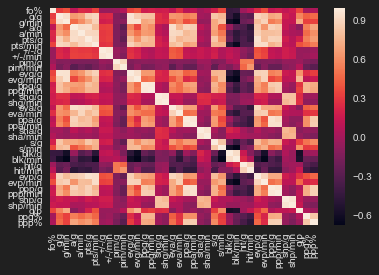

In [16]:
# pick stats to cluster forwards by
#first visualize how the /min stats are correlated
corr = grouped_df[grouped_df.columns[27:]].corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [17]:
cluster_stats = ['fo%', 'g/min', 'a/min', 's/min', 'hit/min', 'blk/min', 'pim/min', 'g/p']

In [18]:
# cluster
k_means = KMeans(init='k-means++', n_clusters=6, n_init=100)
k_means.fit(preprocessing.scale(forwards[cluster_stats]))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=100, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [19]:
# add cluster to df
forwards['cluster'] = k_means.labels_

# get cluster centroids
centers = k_means.cluster_centers_
center_df = pd.DataFrame(centers, columns=cluster_stats)

# get the mean values for each stat
means = []
for col in range(centers.shape[1]):
    means.append(centers[:,col].mean())

# find values relative to mean
rel_values = centers - np.array(means)
rel_df = pd.DataFrame(rel_values, columns=cluster_stats)

# print results
print("\nK-Means Clustering of NHL Forwards:\n")
for i in range(0,len(forwards.cluster.value_counts())):
    print('Group:', i)
    print('{stat:11}{val:7}{rank}'.format(stat='Stat', val='Value', rank='Rank'))
    for j in range(len(cluster_stats)):
        print('{stat:8}: {val:6.2f}  ({rank:.0f}/{of})'.format(stat=cluster_stats[j],
                                         rank=rel_df.rank(ascending=False).iloc[i].values[j],
                                         val=rel_df.iloc[i].values[j],
                                         of=len(rel_df)))
    print('\nTypical players:')
    for j in range(5):
        print('-',forwards[forwards.cluster==i].sort_values(by='atoi', ascending=False)['name'].head().values[j])
    print('--------------------\n')


K-Means Clustering of NHL Forwards:

('Group:', 0)
Stat       Value  Rank
fo%     :  -0.01  (4/6)
g/min   :   1.66  (1/6)
a/min   :   0.85  (2/6)
s/min   :   1.51  (1/6)
hit/min :  -0.75  (5/6)
blk/min :  -0.51  (5/6)
pim/min :  -0.65  (5/6)
g/p     :   0.58  (2/6)

Typical players:
('-', 'Patrick Kane')
('-', 'John Tavares')
('-', 'Sidney Crosby')
('-', 'Evander Kane')
('-', 'Blake Wheeler')
--------------------

('Group:', 1)
Stat       Value  Rank
fo%     :   0.53  (1/6)
g/min   :  -0.97  (5/6)
a/min   :  -0.53  (5/6)
s/min   :  -0.84  (6/6)
hit/min :  -0.04  (3/6)
blk/min :   1.13  (1/6)
pim/min :  -0.46  (3/6)
g/p     :  -0.63  (5/6)

Typical players:
('-', 'Antoine Vermette')
('-', 'Cody Eakin')
('-', 'Nick Bonino')
('-', 'Matt Read')
('-', 'Curtis Glencross')
--------------------

('Group:', 2)
Stat       Value  Rank
fo%     :   0.42  (3/6)
g/min   :   0.17  (3/6)
a/min   :  -0.48  (4/6)
s/min   :   0.01  (3/6)
hit/min :   0.30  (2/6)
blk/min :   0.16  (3/6)
pim/min :  -0.45  (

From experience watching hockey, these groups are very representative.

I would call these groups:
-  Shut down players, faceoff specialist
-  Playmakers
-  Goal Scorers
-  Checkers
-  Power Forwards
-  Utility, two-way players

In [20]:
# now for the defensemen
cluster_stats = ['g/min', 'a/min', 's/min', 'hit/min', 'blk/min', 'pim/min', '+/-/min', 'ppp/min']

In [21]:
# Try 4 clusters
k_means = KMeans(init='k-means++', n_clusters=4, n_init=100)
k_means.fit(preprocessing.scale(defense[cluster_stats]))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=100, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [22]:
# add cluster to df
defense['cluster'] = k_means.labels_

# get cluster centroids
centers = k_means.cluster_centers_
center_df = pd.DataFrame(centers, columns=cluster_stats)

# get the mean values for each stat
means = []
for col in range(centers.shape[1]):
    means.append(centers[:,col].mean())

# find values relative to mean
rel_values = centers - np.array(means)
rel_df = pd.DataFrame(rel_values, columns=cluster_stats)

# print results
print("\nK-Means Clustering of NHL Defensemen:\n")
for i in range(0,len(defense.cluster.value_counts())):
    print('Group:', i)
    print('{stat:11}{val:7}{rank}'.format(stat='Stat', val='Value', rank='Rank'))
    for j in range(len(cluster_stats)):
        print('{stat:8}: {val:6.2f}  ({rank:.0f}/{of})'.format(stat=cluster_stats[j],
                                         rank=rel_df.rank(ascending=False).iloc[i].values[j],
                                         val=rel_df.iloc[i].values[j],
                                         of=len(rel_df)))
    print('\nTypical players:')
    for j in range(5):
        print('-',defense[defense.cluster==i].sort_values(by='atoi', ascending=False)['name'].head().values[j])
    print('--------------------\n')


K-Means Clustering of NHL Defensemen:

('Group:', 0)
Stat       Value  Rank
g/min   :  -0.90  (4/4)
a/min   :  -0.92  (4/4)
s/min   :  -0.79  (3/4)
hit/min :   1.40  (1/4)
blk/min :   0.41  (2/4)
pim/min :   1.20  (1/4)
+/-/min :  -0.33  (4/4)
ppp/min :  -1.03  (4/4)

Typical players:
('-', 'Alexei Emelin')
('-', 'Robyn Regehr')
('-', 'Kevin Bieksa')
('-', 'Brooks Orpik')
('-', 'Erik Gudbranson')
--------------------

('Group:', 1)
Stat       Value  Rank
g/min   :  -0.73  (3/4)
a/min   :  -0.74  (3/4)
s/min   :  -0.85  (4/4)
hit/min :  -0.26  (2/4)
blk/min :   0.57  (1/4)
pim/min :  -0.45  (4/4)
+/-/min :   0.09  (2/4)
ppp/min :  -0.86  (3/4)

Typical players:
('-', 'Francois Beauchemin')
('-', 'Andy Greene')
('-', 'Kris Russell')
('-', 'Jay Bouwmeester')
('-', 'Jaccob Slavin')
--------------------

('Group:', 2)
Stat       Value  Rank
g/min   :   0.11  (2/4)
a/min   :   0.14  (2/4)
s/min   :   0.36  (2/4)
hit/min :  -0.43  (3/4)
blk/min :  -0.42  (3/4)
pim/min :  -0.37  (2/4)
+/-/min

It's a little more difficult to seperate defensemen as there aren't as many of them and their styles are similar, but I would call these groups:
-  Second pairing defensemen
-  Top pairing, powerplay quarterbacks
-  Physical, stay at home defensemen
-  Puck movers, offensive

#### This is a good start but I'd like to try using advanced possesion statistics like Corsi, Fenwick, and scoring chances.  It might also be intersting to compare these results with kNN, hierarchical clustering, or try using CH score/ Gap statistics to estimate the number of clusters